In [136]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import random
import csv

random.seed(42)

def load_data(file_name, max_labels=100):
    data = []
    labels_counter = {}
    with open(file_name, 'r', encoding="utf-8") as file:
        first = True
        for row in csv.reader(file):
            if not first:
                label = int(row[0])-1
                if label in [0,1,2]:
                    data.append(((row[1]+' '+row[2]), label))
            else:
                first = not first
    random.shuffle(data)
    X, y = [], []
    for row in data:
        label = row[1]
        if label not in labels_counter.keys():
            labels_counter[label] = 0
        if labels_counter[label] < max_labels:
            labels_counter[label]+=1
            X.append(row[0])
            y.append(label)
    return X, y

X_doc_train, y_train = load_data(r".\train.csv")
X_doc_test, y_test = load_data(r".\test.csv", 80)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [137]:
vectorizer = CountVectorizer(token_pattern=r'\b[a-zA-Z]+\b', stop_words='english')
X_train = vectorizer.fit_transform(X_doc_train)
X_test = vectorizer.transform(X_doc_test)
vocab = vectorizer.get_feature_names_out()

In [138]:
class MyMultinomialNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        n_features = X.shape[1]
        # априорные вероятности классов
        self._class_count = np.array([np.sum(y == c) for c in self._classes])
        self._class_prior = self._class_count / y.shape[0]
        # количество слов по классам
        self._feature_count = np.zeros((n_classes, n_features))
        for c in self._classes:
            X_c = X[y == c]
            self._feature_count[c, :] = np.asarray(X_c.sum(axis=0)).ravel()
        # тотальное число слов в каждом классе
        self._feature_sum = self._feature_count.sum(axis=1)
        # вероятности слов
        self._feature_prob = (self._feature_count + self.alpha) / (
            self._feature_sum[:, None] + self.alpha * n_features
        )
        return self

    def predict_proba(self, X):
        # log(p(C)) + sum log(p(word|C))
        log_prior = np.log(self._class_prior)
        log_likelihood = X @ np.log(self._feature_prob).T
        log_posterior = log_prior + log_likelihood
        # нормализация в вероятности
        log_posterior -= log_posterior.max(axis=1, keepdims=True)
        posterior = np.exp(log_posterior)
        posterior /= posterior.sum(axis=1, keepdims=True)
        return posterior

    def predict(self, X):
        proba = self.predict_proba(X)
        return self._classes[np.argmax(proba, axis=1)]

In [139]:
my_multi = MyMultinomialNB(alpha=1.0)
my_multi.fit(X_train, y_train)
pred_multi_my = my_multi.predict(X_test)
print(classification_report(y_test, pred_multi_my))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        80
           1       0.99      0.90      0.94        80
           2       0.93      0.99      0.96        80

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



In [140]:
multi_clf = MultinomialNB(alpha=1.0)
multi_clf.fit(X_train, y_train)

pred_multi_sklearn = multi_clf.predict(X_test)
print(classification_report(y_test, pred_multi_sklearn))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        80
           1       0.99      0.90      0.94        80
           2       0.93      0.99      0.96        80

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



In [141]:
def find_params(model, X_train, y_train, name, k_values=np.logspace(-5, 1, 50)):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results = []
    res_f1 = -np.inf
    res_alpha = None

    for k in k_values:
        f1_scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            clf = model(alpha=k)
            clf.fit(X_tr, y_tr)
            y_pred = clf.predict(X_val)
            f1_scores.append(f1_score(y_val, y_pred, average='macro'))
        mean_f1 = np.mean(f1_scores)
        if mean_f1>res_f1:
            res_f1 = mean_f1
            res_alpha = k
        results.append(np.mean(f1_scores))

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, results)
    plt.xlabel('alpha')
    plt.ylabel('F1 Score')
    plt.title(f'Зависимость F1-score от alpha для разных метрик ({name})')
    plt.grid(True)
    plt.show()
    return (res_alpha, res_f1)
    


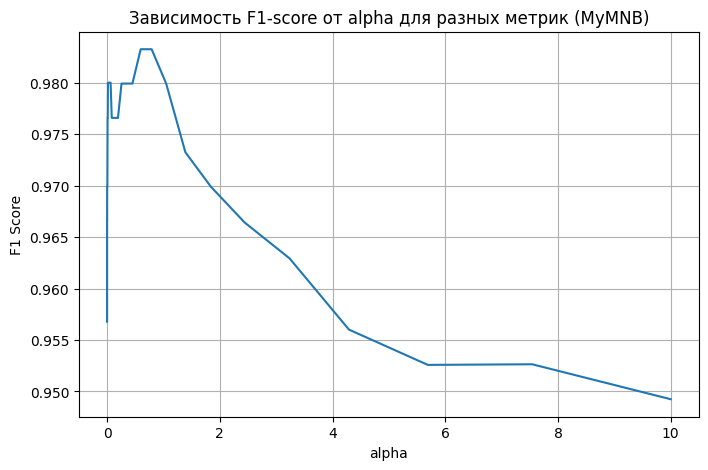

(np.float64(0.5963623316594636), np.float64(0.9832457786116322))

In [142]:
res_alpha, res_f1 = find_params(MyMultinomialNB, X_train, y_train, "MyMNB")
res_alpha, res_f1

In [143]:
my_multi = MyMultinomialNB(alpha=0.5963623316594636)
my_multi.fit(X_train, y_train)
pred_multi_my = my_multi.predict(X_test)
print(classification_report(y_test, pred_multi_my))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        80
           1       0.99      0.90      0.94        80
           2       0.93      0.99      0.96        80

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



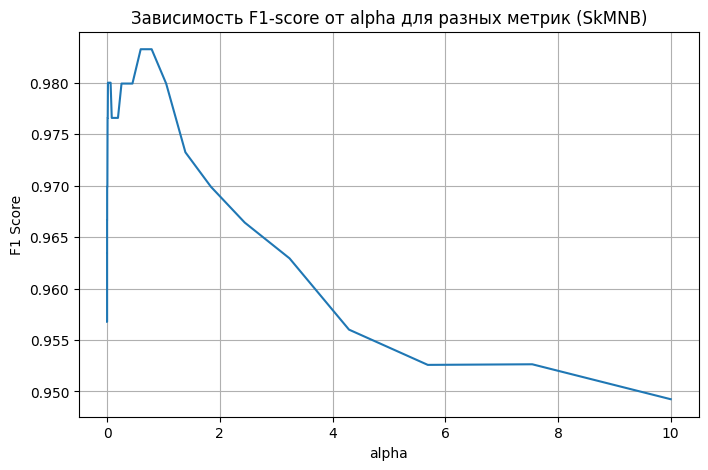

(np.float64(0.5963623316594636), np.float64(0.9832457786116322))

In [144]:
res_alpha, res_f1 = find_params(MultinomialNB, X_train, y_train, "SkMNB")
res_alpha, res_f1

# Отчет

В ходе выполнения лабораторной работы была выполнена реализация своего алгоритма машинного обучения MultinomialNB для классификации текстов. Было произведено сравнение результатов работу собственной реализации и реализации из sklearn. Никаких различий обнаружено не было. Также был проведен подбор параметра сглаживания alpha при помощи К-фолдов. Таким образом, оптимальным оказалось значение alpha ~= 0.6 с F1 Score ~=0.983.